# Create new utility function

Import data.

In [ ]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

In [ ]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

Create inputs to the DrugEnv.

In [ ]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create molecular properties
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')

# create docking oracle
config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 14.328,
    'size_y': 8.85,
    'size_z': 12.539,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path=f'{path}/Mpro_prepped.pdbqt',
    config=config
)

# create evaluators
log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))
docking_evaluator = ClassicEvaluator(ideal=(-12, -9), acceptable=(-12, -7))

# create utility function
utility_function = UtilityFunction(
    oracles = [docking_oracle, log_S_oracle, log_P_oracle],
    evaluators = [docking_evaluator, log_S_evaluator, log_P_evaluator],
    strategy = lambda x: np.multiply(*x)
)

# utility = utility_function(deck)
# worst_molecules = utility.argsort().tolist()[:25]

In [10]:
%%time
utility_function(deck[-20:])

CPU times: user 2.48 s, sys: 302 ms, total: 2.79 s
Wall time: 4.54 s


array([0.25666225, 0.15901349, 0.0699117 , 0.07191242, 0.06565368,
       0.06091665, 0.10871092, 0.16957218, 0.08295604, 0.12455013,
       0.07269802, 0.17001788, 0.09506825, 0.08521046, 0.15007938,
       0.119183  , 0.08853248, 0.09564901, 0.12562639, 0.12875435])

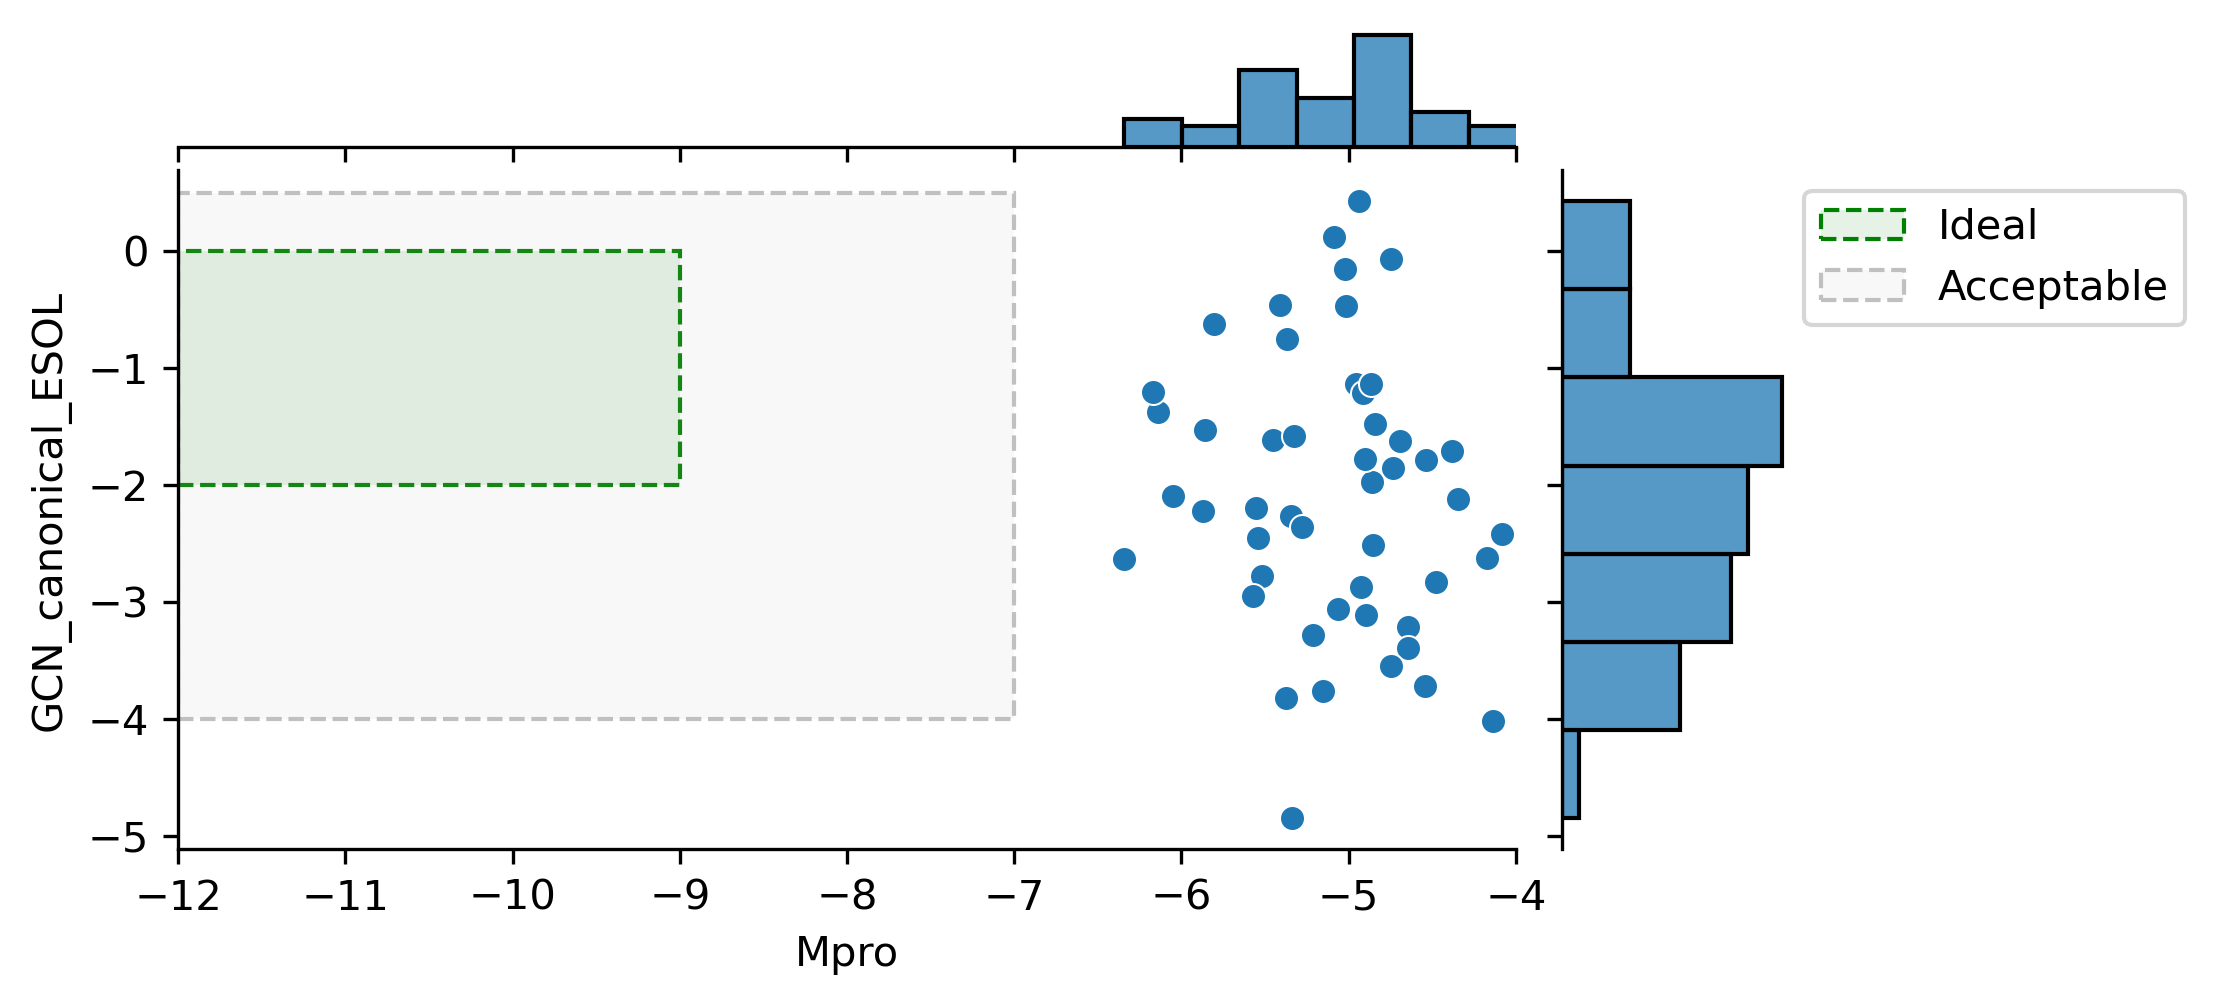

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

g = utility_function.plot(deck[:50], plot_cycle=False)

g.ax_joint.set_xlim(-12, -4)
# g.ax_joint.set_ylim(-3, 6)
plt.show()

First, set up the environment.

In [ ]:
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials):
        
        results = []
        for trial in tqdm(range(num_trials)):
            
            observations, info = drug_env.reset()
            while True:
                
                action = drug_agent.act(observations)
                observations, reward, terminated, truncated, info = drug_env.step(action)
                result = {
                    'trial': trial,
                    'epsilon': self.drug_agent.epsilon,
                    'fraction_random': self.drug_agent.fraction_random,
                    'num_analogs': self.drug_agent.num_analogs,
                    'branch_factor': self.drug_agent.branch_factor
                }
                
                if terminated:
                    cost = len(drug_env.library) - len(drug_env._library_0)
                    result.update({'cost': cost, 'outcome': 1})
                    break
                
                if truncated:
                    result.update({'outcome': 0})
                    break

            results.append(result)
        return results

In [ ]:
drug_env = DrugEnv(
    library_designer,
    library = deck[:5],
    assays = utility_function.oracles,
    budget = 10_000,
    utility_function = utility_function,
)
drug_agent = SequentialDrugAgent(
    action_space = drug_env.action_space,
    utility_function = utility_function,
    epsilon = 0.33,
    fraction_random = 0.0,
    num_analogs = 1,
    branch_factor = 5
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1)

In [83]:
rdkit.Chem.MolFromSmiles(sm)

In [82]:
import selfies as sf
sm = "CCCn1ccc(-c2ccncc2)[nH]1"

rdkit.Chem.SanitizeMol(rdkit.Chem.MolFromSmiles(sm))

ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.SanitizeMol(NoneType)
did not match C++ signature:
    SanitizeMol(RDKit::ROMol {lvalue} mol, unsigned long sanitizeOps=rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_ALL, bool catchErrors=False)

In [28]:
'CC(C)(C)NC(=O)NC(=O)C1CCNCC1' in experiment.drug_env.utility_function.oracles[0].cache

False

Experimenting with Agent hyperparameters.

In [58]:
results = []
branch_factors = [1, 2, 4]
for branch_factor in branch_factors:
    print(branch_factor)
    result = run_experiment(
        # experiment
        num_trials = 50,

        # env
        library = deck[worst_molecules],
        epsilon = epsilon,

        # agent
        fraction_random = 0.2,
        num_analogs = 1,
        branch_factor = 2
    )
    results.extend(result)

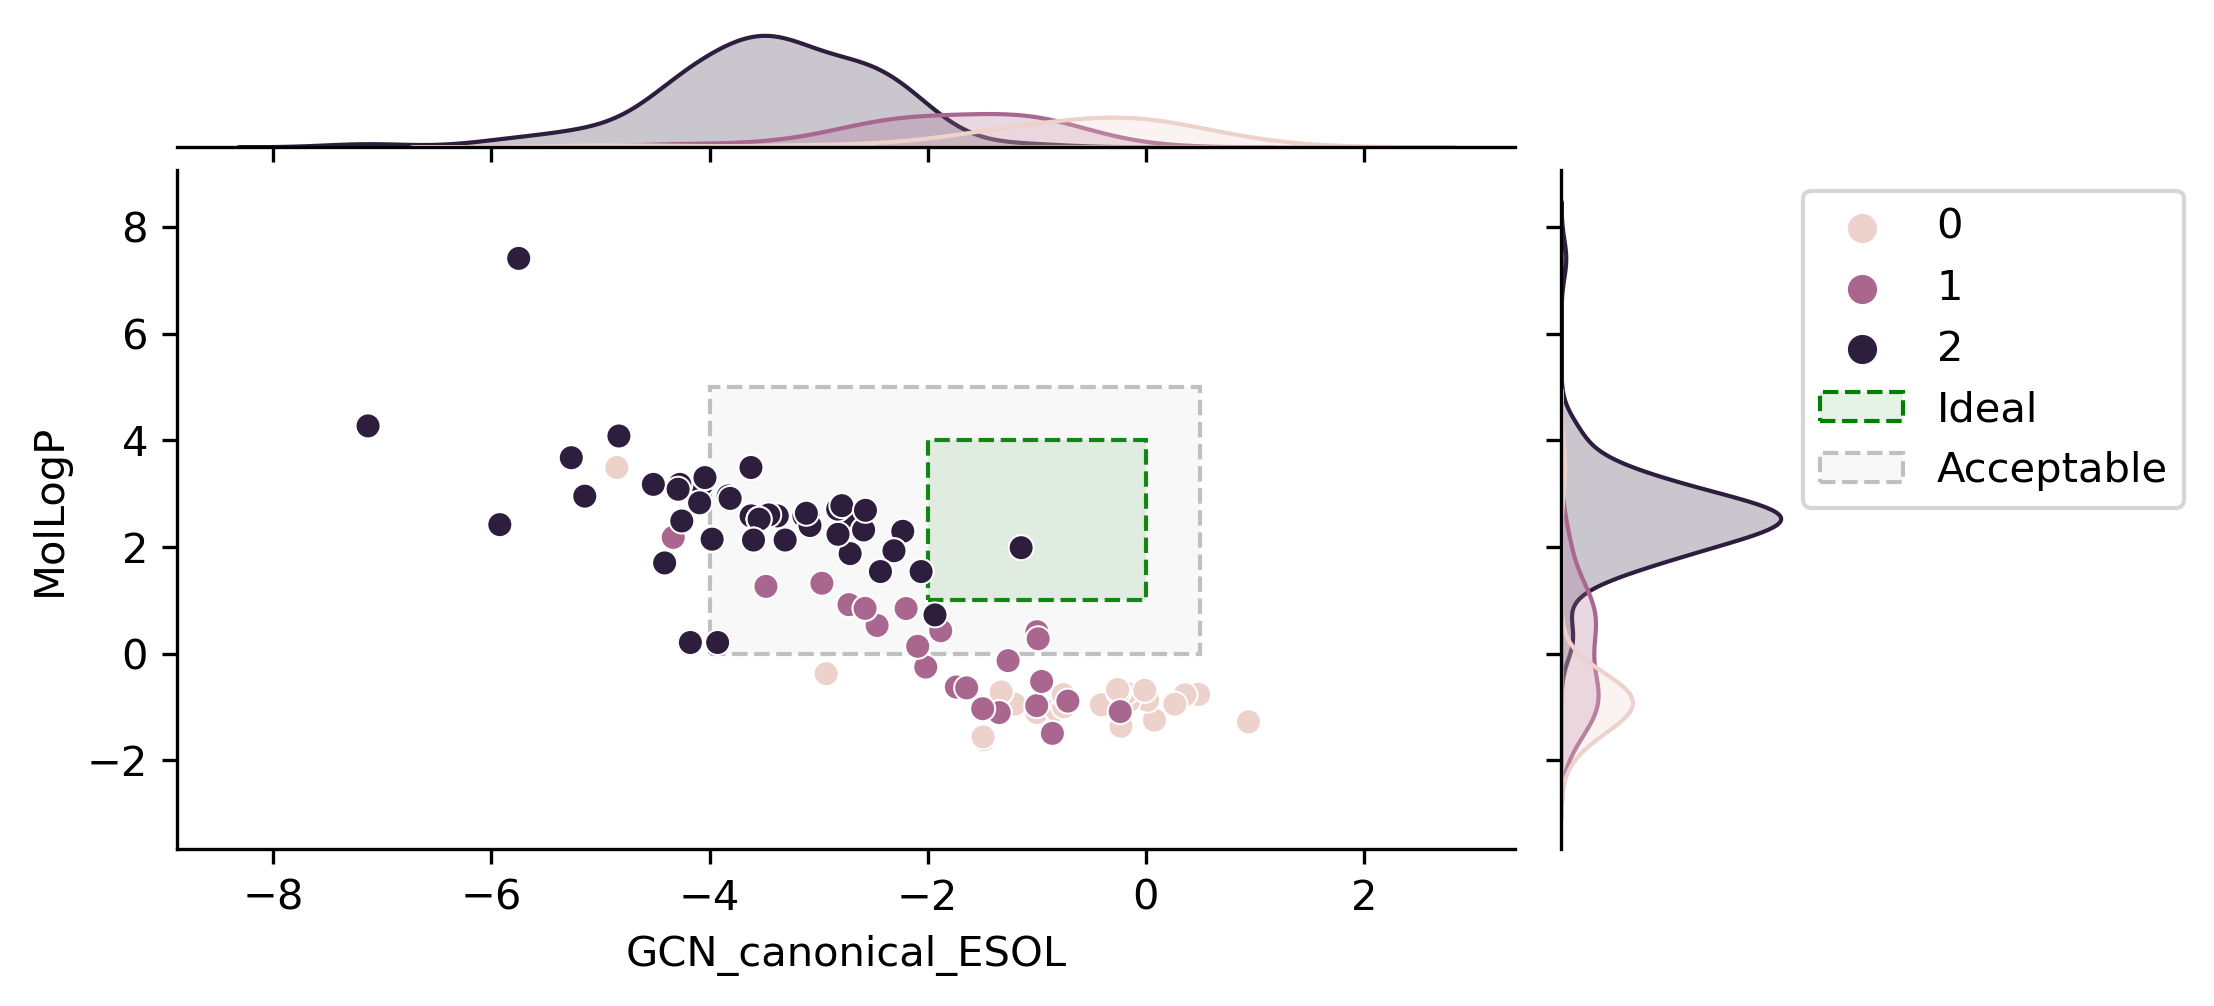

In [59]:
# sns.reset_defaults()
# g = utility_function.plot(drug_env.library)

# # g.ax_joint.set_xlim(-9, 1.5)
# # g.ax_joint.set_ylim(-3, 6)
# plt.show()

In [60]:
def ecdf(costs):
    costs = np.array([c for c in costs])
    costs_sorted = np.sort(costs)
    probs = 1. * np.arange(1, len(costs) + 1) / len(costs)

    costs_sorted = np.concatenate([[0.0], costs_sorted])
    probs = np.concatenate([[0.0], probs])
    
    return costs_sorted, probs

In [63]:
data = pd.DataFrame()
for epsilon in epsilons:
    raw_costs = [r['cost'] for r in df.to_dict('records') if r['epsilon'] == epsilon]
    cost, prob = ecdf(raw_costs)
    temp = pd.DataFrame({'cost': cost, 'prob': prob, 'epsilon': epsilon})
    data = pd.concat([data, temp])

AttributeError: 'NoneType' object has no attribute 'to_dict'

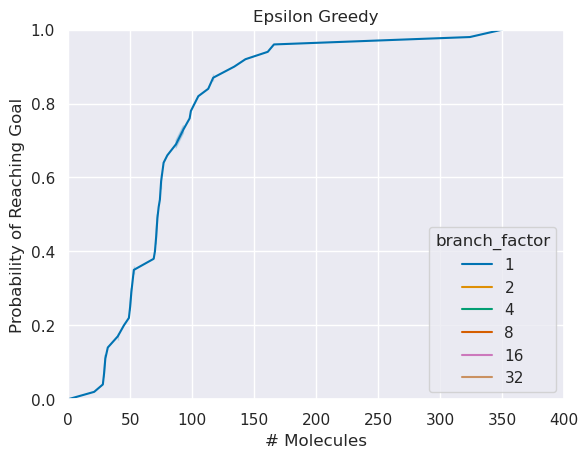

In [64]:
sns.set()
g = sns.lineplot(
    data,
    x='cost',
    y='prob',
    hue='epsilon',
    palette='colorblind'
)

g.set_title('Epsilon Greedy')
g.set_xlabel('# Molecules')
g.set_ylabel('Probability of Reaching Goal')
g.set_ylim([0, 1])
g.set_xlim(0, 500)

plt.gcf().set_dpi(150)
plt.show()

Draw lineage of best molecule.

In [65]:
from rdkit.Chem import Draw

utility = drug_agent.policy(observations)
index = int(np.argsort(utility)[-1])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

assay_results = [assay(lineage) for assay in assays]
results = [
    utility_function.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
display(*zip(*assay_results))

NameError: name 'assays' is not defined